# Imports

In [1]:
import pickle
import wbgapi as wb
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from yellowbrick.regressor import residuals_plot, ResidualsPlot
from yellowbrick.regressor import prediction_error

from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoLars

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split


# Models

In [2]:
MODELS = {
    "LassoLars": LassoLars(alpha=.1, normalize=False),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet":ElasticNet(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(max_depth=5, random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=5),
    "GradientBoostingRegressor" :GradientBoostingRegressor(n_estimators=100),
    "AdaBoostRegressor" : AdaBoostRegressor(n_estimators=100),
    "XGBRegressor": XGBRegressor(max_depth=3, n_estimators=100, n_jobs=3,
                           objective='reg:squarederror',
                           random_state=42, learning_rate=0.03),
    "K-nn": KNeighborsRegressor(),
    "LinearRegression":LinearRegression(),
    "CatBoostRegressor":CatBoostRegressor(loss_function='RMSE',silent=True, depth=5),
    "LGBMRegressor":LGBMRegressor()
    
}

# Functions

In [3]:
def read_data(codes):
    wb.db = 2
    worldbank_data = wb.data.DataFrame(codes, 
                                       ['DEU', 'AUS', 'CAN', 'USA', 'FRA', 'ITA', 'JPN', 'GBR', 'ZAF', 'SAU', 'ARG', 'BRA', 'CHN', 'KOR', 'IND', 'IDN', 'MEX', 'RUS', 'TUR'],
                                      range(1990, 2020, 1))
    return worldbank_data

In [4]:
def read_data1(codes):
    wb.db = 1
    worldbank_data = wb.data.DataFrame(codes, 
                                       ['DEU', 'AUS', 'CAN', 'USA', 'FRA', 'ITA', 'JPN', 'GBR', 'ZAF', 'SAU', 'ARG', 'BRA', 'CHN', 'KOR', 'IND', 'IDN', 'MEX', 'RUS', 'TUR'],
                                      range(1990, 2020, 1))
    return worldbank_data

In [5]:
def get_data(data):
    dict_data={}
    
    for index, row in data.items():
        if len(row)>19:
            for index2, row2 in row.items():          
                if not dict_data.get(index2[1]):
                    dict_data[index2[1]]=[]
                dict_data.get(index2[1]).append(row2)
        else:
            for index2, row2 in row.items():
                if not dict_data.get("coluna"):
                    dict_data["coluna"]=[]
                dict_data.get("coluna").append(row2)
    return pd.DataFrame(dict_data)

In [6]:
def get_the_best_model(input,output):
    data_input = get_data(input)
    data_output = get_data(output)
    
    normalizer = MinMaxScaler(feature_range = (-1, 1))
    

    
    data = pd.concat([data_input,data_output],axis=1)
    
    
     
    data = normalizer.fit_transform(np.nan_to_num(data_input.values))
    
    x = data
    y = data_output.values
    y =np.ravel(y)
    print("x-shape: ", x.shape)
    print("y-shape: ", y.shape)

    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=42)
    y_test_predict = dict()
    y_mse = dict()

    the_best ={"R_squared": -1, 'model':dict() }

    for name, estimator in MODELS.items():
        try:
            if(name =='LGBMRegressor'):
                estimator.fit(X_train, y_train)  
            else:
                estimator.fit(X_train, y_train)  
        except Exception as e:
           
            print(f'error-> {e}')
            print(X_train.dtype)
            print(y_train.dtype)
            continue
        y_test_predict[name] = estimator.predict(X_test) 

        # Metrics
        y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
        y_true = y_test 

        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
        n_scores = cross_val_score(estimator, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=3)
        n_scores = np.absolute(n_scores)

        MSE = mean_squared_error(y_true, y_test_predict[name])
        RMSE = np.sqrt(MSE)
        R_squared = r2_score(y_true, y_test_predict[name],multioutput="variance_weighted")
        MAE = np.mean(n_scores)
     
        if(R_squared> the_best.get('R_squared')):
            the_best['RMSE'] = RMSE
            the_best['MSE'] = MSE
            the_best['R_squared']= R_squared
            the_best['model']={'name':name, 'estimator': estimator}

    print('The best model',the_best.get('model').get('name'))
    print("R-squared", the_best.get("R_squared"))
    try:
        # Making the Residuals Plot
        print("Residuals Plot")
        residuals_plot(the_best.get('model').get('estimator'), X_train, y_train, X_test, y_test)
    except:
        print()
    try:
        # Making the Prediction Error Plot
        print("Prediction Error Plot")
        prediction_error(the_best.get('model').get('estimator'), X_train, y_train, X_test, y_test)
    except:
        print()
        
    return [the_best.get('model').get('estimator'), normalizer]

In [7]:
def save(nome, model, normalizer, normalizer_out):
    with open(f'../models/normalizer_{nome}.pkl','wb') as f:
        pickle.dump(normalizer,f)
    with open(f'../models/model_{nome}.pkl','wb') as f:
        pickle.dump(model,f)
    with open(f'../models/normalizer_{nome}_out.pkl','wb') as f:
        pickle.dump(normalizer_out,f)
    print('salvo')

In [8]:
def to_negative(df, ouputs_negative):
    for i in ouputs_negative:
        df.loc[df.index.get_level_values('series') == i] = df.loc[df.index.get_level_values('series') == i] * -1
    return df

# Ministérios

## Agricultura e desenvolvimento rural

## Inputs

In [9]:
inputs_agricultura= ['NV.AGR.TOTL.CD']
df_inputs_agricultura = read_data(inputs_agricultura)
df_inputs_agricultura.fillna(df_inputs_agricultura.mean(), inplace=True)

## Outputs

In [10]:
outputs_agricultura = ['SL.AGR.EMPL.ZS','SP.RUR.TOTL.ZS','AG.PRD.FOOD.XD']
df_outputs_agricultura = read_data(outputs_agricultura)
df_outputs_agricultura.fillna(df_outputs_agricultura.mean(), inplace=True)
df_outputs_agricultura = df_outputs_agricultura.groupby(level=0).sum()

## Model

x-shape:  (570, 1)
y-shape:  (570,)
The best model Decision Tree Regressor
R-squared 0.450026133863233
Residuals Plot


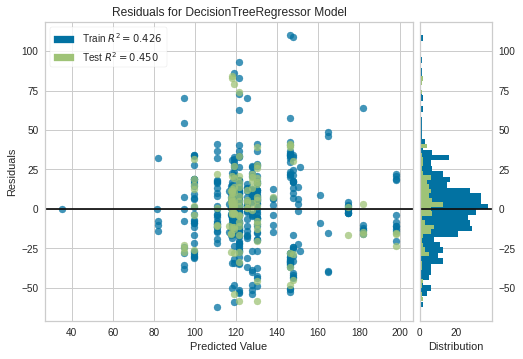

Prediction Error Plot


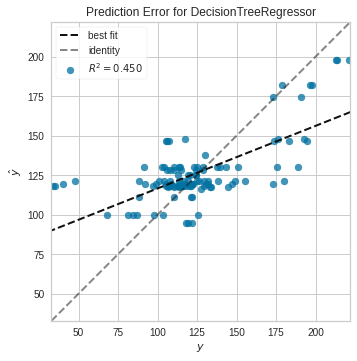

In [11]:
model_agricultura, normalizer_agricultura =  get_the_best_model(df_inputs_agricultura,df_outputs_agricultura)

In [12]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_agricultura))

MinMaxScaler(feature_range=(-100, 100))

In [13]:
save('agricultura',model_agricultura,normalizer_agricultura,normalizer_out)

salvo


## Educação

## Inputs

In [14]:
inputs_educacao=["SE.XPD.PRIM.ZS", "SE.XPD.SECO.ZS", "SE.XPD.TERT.ZS"]
df_inputs_educacao = read_data(inputs_educacao)
df_inputs_educacao.fillna(df_inputs_educacao.mean(), inplace=True)

## Outputs Negative

In [15]:
ouputs_negative_educacao = ['SE.SEC.CMPT.LO.ZS','SE.SEC.UNER.LO.ZS','SE.PRM.UNER.ZS']

## Outputs

In [16]:
outputs_educacao = ["SE.ADT.LITR.ZS","SE.ADT.1524.LT.ZS","SE.PRM.CMPT.ZS"]
df_outputs_educacao = read_data(outputs_educacao)
df_outputs_educacao.fillna(df_outputs_educacao.mean(), inplace=True)
df_outputs_educacao = to_negative(df_outputs_educacao, ouputs_negative_educacao)
df_outputs_educacao=df_outputs_educacao.groupby(level=0).sum()

## Model

x-shape:  (570, 3)
y-shape:  (570,)
The best model K-nn
R-squared 0.1638889506976491
Residuals Plot


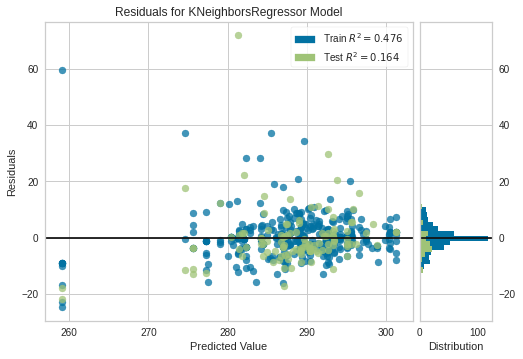

Prediction Error Plot


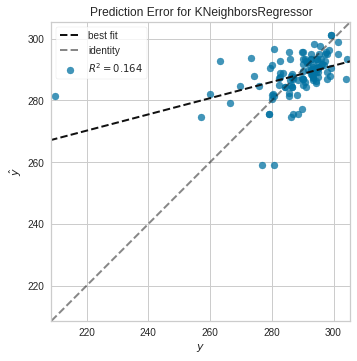

In [17]:
model_educacao, normalizer_educacao =  get_the_best_model(df_inputs_educacao,df_outputs_educacao)

In [18]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_educacao))

MinMaxScaler(feature_range=(-100, 100))

In [19]:
save('educacao',model_educacao, normalizer_educacao, normalizer_out)

salvo


## Mudanças climáticas e meio ambiente

## Inputs

In [20]:
inputs_ambiente = ["EN.ATM.METH.AG.ZS","EN.ATM.NOXE.AG.ZS","EN.ATM.CO2E.GF.ZS"]
df_inputs_ambiente = read_data(inputs_ambiente)
df_inputs_ambiente.fillna(df_inputs_ambiente.mean(), inplace=True)

## Ouputs

In [21]:
outputs_ambiente = ["EG.ELC.ACCS.ZS","EG.ELC.HYRO.ZS","EG.ELC.RNWX.ZS"]
df_outputs_ambiente = read_data(outputs_ambiente)
df_outputs_ambiente.fillna(df_outputs_ambiente.mean(), inplace=True)
df_outputs_ambiente=df_outputs_ambiente.groupby(level=0).sum()

## Model

In [22]:
model_ambiente,normalizer_ambiente=get_the_best_model(df_inputs_ambiente, df_outputs_ambiente)

x-shape:  (570, 3)
y-shape:  (570,)
The best model CatBoostRegressor
R-squared 0.9630779688046048
Residuals Plot

Prediction Error Plot



In [23]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_ambiente))

MinMaxScaler(feature_range=(-100, 100))

In [24]:
save('ambiente',model_ambiente,normalizer_ambiente,normalizer_out)

salvo


## Saúde

## Input

In [25]:
inputs_saude = ['SH.XPD.CHEX.GD.ZS']
df_inputs_saude = read_data(inputs_saude)
df_inputs_saude.fillna(df_inputs_saude.mean(), inplace=True)

## Outputs

In [26]:
outputs_saude = ['SH.STA.BASS.ZS','SH.MED.BEDS.ZS','SH.MED.NUMW.P3','SH.MED.PHYS.ZS']
df_outputs_saude = read_data(outputs_saude)
df_outputs_saude.fillna(df_outputs_saude.mean(), inplace=True)
df_outputs_saude = df_outputs_saude.groupby(level=0).sum()

## Model

x-shape:  (570, 1)
y-shape:  (570,)
The best model Linear regression
R-squared 0.24815974024369813
Residuals Plot


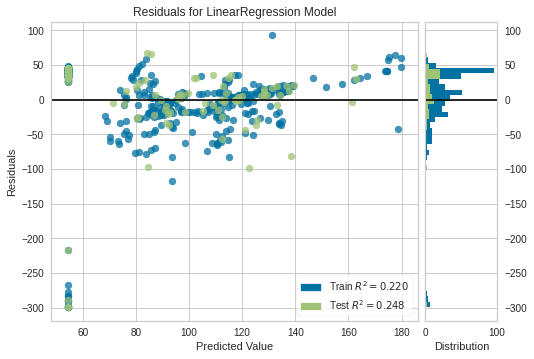

Prediction Error Plot


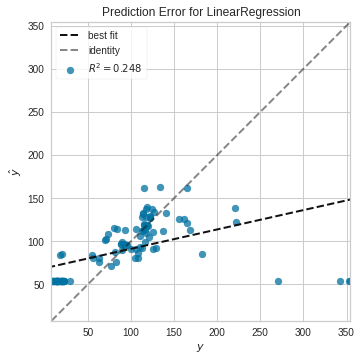

In [27]:
model_saude,normalizer_saude=get_the_best_model(df_inputs_saude, df_outputs_saude)

In [28]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_saude))

MinMaxScaler(feature_range=(-100, 100))

In [29]:
save('saude',model_saude,normalizer_saude,normalizer_out)

salvo


## Infraestreutura, Ciência e Tecnologia

## Input

In [30]:
inputs_ciencia = ['GB.XPD.RSDV.GD.ZS']
df_inputs_ciencia = read_data(inputs_ciencia)
df_inputs_ciencia.fillna(df_inputs_ciencia.mean(), inplace=True)

## Output

In [31]:
outputs_ciencia =['IT.NET.SECR.P6','EP.PMP.SGAS.CD','IP.JRN.ARTC.SC','IP.IDS.NRCT','IP.IDS.RSCT','IS.RRS.GOOD.MT.K6']
df_outputs_ciencia = read_data(outputs_ciencia)
df_outputs_ciencia.fillna(df_outputs_ciencia.mean(), inplace=True)
df_outputs_ciencia=df_outputs_ciencia.groupby(level=0).sum()

## Model

x-shape:  (570, 1)
y-shape:  (570,)
The best model Decision Tree Regressor
R-squared 0.4293782269627092
Residuals Plot


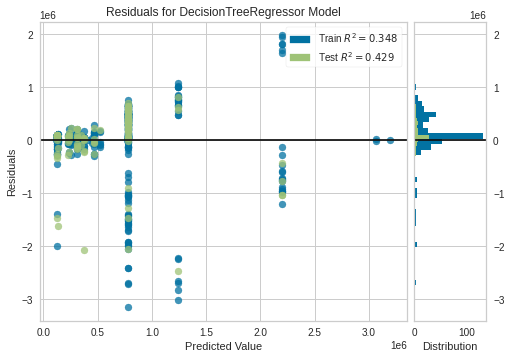

Prediction Error Plot


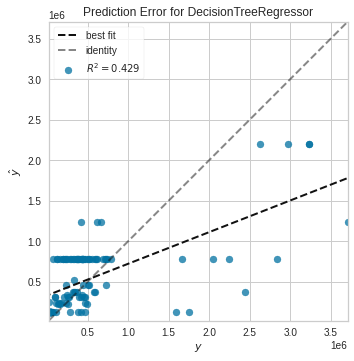

In [32]:
model_ciencia,normalizer_ciencia=get_the_best_model(df_inputs_ciencia, df_outputs_ciencia)

In [33]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_ciencia))

MinMaxScaler(feature_range=(-100, 100))

In [34]:
save('ciencia',model_ciencia,normalizer_ciencia,normalizer_out)

salvo


## Desenvolvimento 

## Input

In [35]:
inputs_desenvolvimento = ['SI.POV.GINI']
df_inputs_desenvolvimento = read_data(inputs_desenvolvimento)
df_inputs_desenvolvimento.fillna(df_inputs_desenvolvimento.mean(), inplace=True)

## Negative Output

In [36]:
negative_ouputs_desenvolvimento = ['SI.DST.50MD']

## Output

In [37]:
outputs_desenvolvimento = ['SL.EMP.VULN.ZS','SL.UEM.TOTL.NE.ZS','SI.DST.50MD']
df_outputs_desenvolvimento = read_data(outputs_desenvolvimento)
df_outputs_desenvolvimento.fillna(df_outputs_desenvolvimento.mean(), inplace=True)
df_outputs_desenvolvimento = to_negative(df_outputs_desenvolvimento, negative_ouputs_desenvolvimento)
df_outputs_desenvolvimento = df_outputs_desenvolvimento.groupby(level=0).sum()

## Model

x-shape:  (570, 1)
y-shape:  (570,)
The best model Linear regression
R-squared -0.011866399862948905
Residuals Plot


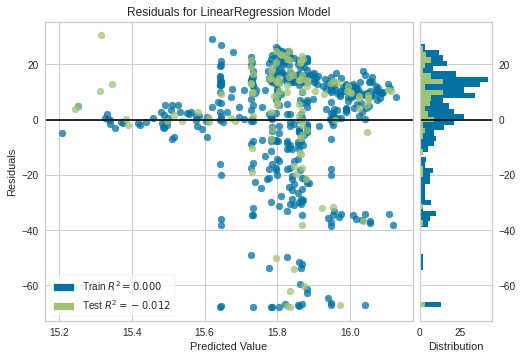

Prediction Error Plot


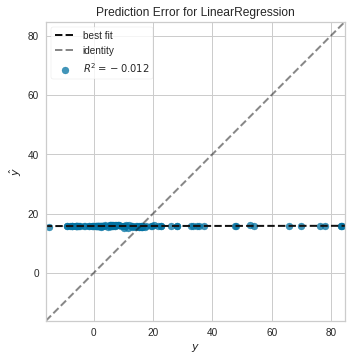

In [38]:
model_desenvolvimento,normalizer_desenvolvimento = get_the_best_model(df_inputs_desenvolvimento, df_outputs_desenvolvimento)

In [39]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_desenvolvimento))

MinMaxScaler(feature_range=(-100, 100))

In [40]:
save('desenvolvimento',model_desenvolvimento,normalizer_desenvolvimento,normalizer_out)

salvo


## Banco Central

## Input

In [41]:
inputs_banco = ['FR.INR.DPST']

In [42]:
df_inputs_banco= read_data(inputs_banco)
df_inputs_banco.fillna(df_inputs_banco.mean(), inplace=True)

## Outputs

In [43]:
outputs_banco = ['FM.LBL.BMNY.GD.ZS','FM.LBL.BMNY.ZG','FP.CPI.TOTL.ZG','NY.GDP.DEFL.KD.ZG.AD','PA.NUS.FCRF']
df_outputs_banco = read_data(outputs_banco)
df_outputs_banco.fillna(df_outputs_banco.mean(), inplace=True)
df_outputs_banco=df_outputs_banco.groupby(level=0).sum()

## Model

x-shape:  (570, 1)
y-shape:  (570,)
The best model XGBRegressor
R-squared 0.24062910703247253
Residuals Plot


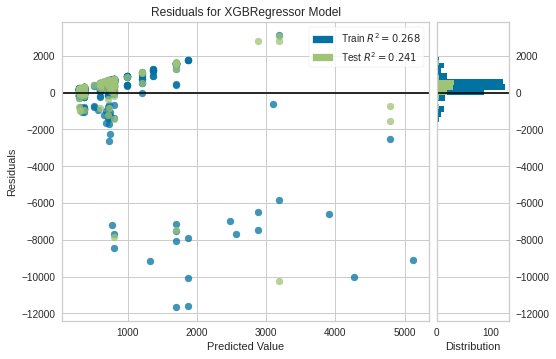

Prediction Error Plot


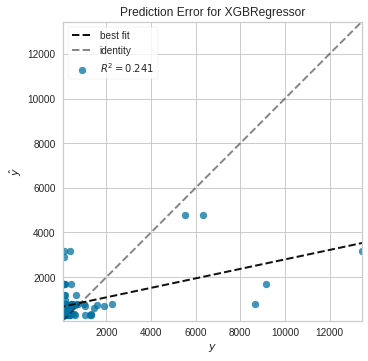

In [44]:
model_banco,normalizer_banco=get_the_best_model(df_inputs_banco, df_outputs_banco)

In [45]:
normalizer_out = MinMaxScaler(feature_range = (-100, 100))
normalizer_out.fit(get_data(df_outputs_banco))

MinMaxScaler(feature_range=(-100, 100))

In [46]:
save('banco',model_banco,normalizer_banco,normalizer_banco)

salvo


# Economia

## Input

In [47]:
inputs_economia =['NV.IND.TOTL.ZS','NV.IND.MANF.ZS','NV.SRV.TOTL.ZS']
df_inputs_economia = read_data(inputs_economia)
df_inputs_economia.fillna(df_inputs_economia.mean(), inplace=True)

## Output

In [52]:
outputs_economia = ['NY.GDS.TOTL.CD','NE.RSB.GNFS.CD','NE.CON.TOTL.CD']
df_outputs_economia = read_data(outputs_economia)

df_outputs_economia.fillna(df_outputs_economia.mean(), inplace=True)
df_outputs_economia=df_outputs_economia.groupby(level=0).sum()

## Model

In [ ]:
model_economia, normalizer_economia = get_the_best_model(df_inputs_economia, df_outputs_economia)

x-shape:  (570, 3)
y-shape:  (570,)


In [ ]:
normalizer_out = MinMaxScaler(feature_range = (-40, 100))
normalizer_out.fit(get_data(df_outputs_economia))

In [ ]:
save('economia', model_economia, normalizer_economia, normalizer_out)